<a href="https://colab.research.google.com/github/Jaesu26/Dacon-Basic/blob/main/%EC%87%BC%ED%95%91%EB%AA%B0%ED%8F%89%EC%A0%90-%EB%B6%84%EB%A5%98-RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 쇼핑몰 리뷰 평점 분류 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import os, re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from glob import glob

warnings.filterwarnings('ignore')

In [2]:
SEED = 22
N_FOLD = 5
SAVE_PATH = './weight'
LEARNING_RATE = 1e-6
EPOCHS = 100
BATCH_SIZE = 64

In [3]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd  '/content/drive/MyDrive/Colab Notebooks/쇼핑몰-평점-분류/Data'

/content/drive/MyDrive/Colab Notebooks/쇼핑몰-평점-분류/Data


In [5]:
# !unzip -o 'dataset.zip의 사본' ## 현재 디렉토리에 존재하는 zip파일을 현재 디렉토리에 압축해제

In [6]:
%cd  '/content/drive/MyDrive/Colab Notebooks/쇼핑몰-평점-분류'

/content/drive/MyDrive/Colab Notebooks/쇼핑몰-평점-분류


In [7]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

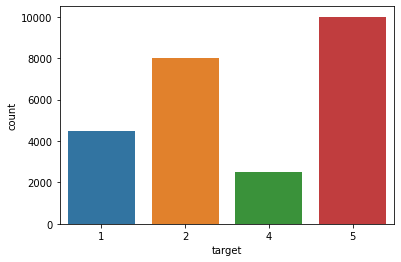

In [150]:
sns.countplot(data=df, x='target')

In [151]:
df['target'].value_counts()

5    10000
2     8000
1     4500
4     2500
Name: target, dtype: int64

## 데이터 전처리

In [8]:
def clean_text(texts): 
    corpus = [] 
    for text in texts: 
        review = re.sub(r'\s+', ' ', text) ## extra space 제거
        review = re.sub(r"^\s+", '', review) ## space from start 제거
        review = re.sub(r'\s+$', '', review) ## space from the end 제거
        corpus.append(review) 

    return corpus

In [9]:
df['clean_reviews'] = clean_text(df['reviews'])
test['clean_reviews'] = clean_text(test['reviews'])

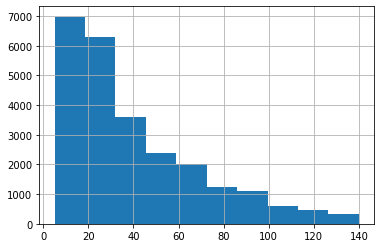

In [10]:
df['clean_reviews'].str.len().hist()

## 데이터 셋 및 딥러닝 모델 정의

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
import gc

- 가중치 저장 폴더 생성

In [12]:
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError as error:
        print(error)

In [13]:
create_folder(SAVE_PATH)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [16]:
## accuracy 계산
def ACCURACY(true, pred):
    return sum(true == pred) / len(true)

In [17]:
def seed_everything(seed: int = 22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [18]:
seed_everything(SEED) ## 재현을 위한 seed 고정

In [100]:
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(1, 3), max_features=20000, sublinear_tf=True)

In [101]:
train_tfidf = tfidf.fit_transform(df['clean_reviews'])
test_tfidf = tfidf.transform(test['clean_reviews'])

In [21]:
target = df['target'].copy()

In [22]:
target = target.map({1:0, 2:1, 4:2, 5:3})

- 데이터 셋

In [23]:
class CustomDataset(Dataset):
  
    def __init__(self, csr_matrix, labels=None, transform=None, target_transform=None):
        self.X = csr_matrix  ## 희소행렬
        self.labels = labels  ## 라벨
        self.transform = transform  ## X 변환방법
        self.target_transform = target_transform ## 라벨 변환방법
    
    def __getitem__(self, idx):
        data = self.X[idx]
        if self.transform is not None: 
            data = self.transform(data) 
            
        if self.labels is not None:
            label = self.labels[idx]
            if self.target_transform:
                label = self.target_transform(label)             
            return data, label  ## train   
        
        return data  ## test는 라벨이 없다
    
    def __len__(self):
        return self.X.shape[0] ## 데이터 개수 반환

In [64]:
## 커스텀 train 데이터 로더를 위한 함수
def collate_batch_train(batch):
    """희소행렬이 input으로 들어오면 batch에 해당하는 부분만 텐서로 변환하여 리턴"""
    text_list = []
    label_list = []
    for text_tfidf, text_class in batch:
        text_list.append(text_tfidf.toarray())
        label_list.append(text_class)

    label_tensor = torch.tensor(np.array(label_list), dtype=torch.int64) 
    text_tensor = torch.tensor(np.array(text_list), dtype=torch.float32)
    return text_tensor, label_tensor

In [63]:
## 커스텀 test 데이터 로더를 위한 함수
def collate_batch_test(batch):
    """희소행렬이 input으로 들어오면 batch에 해당하는 부분만 텐서로 변환하여 리턴"""
    text_list = []
    for text_tfidf in batch:
        text_list.append(text_tfidf.toarray())

    text_tensor = torch.tensor(np.array(text_list), dtype=torch.float32) 
    return text_tensor

`-` 데이터 셋의 아웃풋이 데이터 로더의 인풋이다

`-` 그리고 데이터 로더의 아웃풋을 조정하는 DataLoader의 메소드가 collate_fn이다

- RNN

In [103]:
input_size = train_tfidf.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 4

In [95]:
## RNN class 정의 (many-to-one)
## 코드: https://velog.io/@sjinu/Pytorch-Implementation-code

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__() ## 상속한 nn.Module에서 RNN에 해당하는 init 실행
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, num_classes)

    def forward(self, x): 
        ## input x : (BATCH, LENGTH, INPUT_SIZE) 입니다 (다양한 length를 다룰 수 있습니다.).
        ## 최초의 hidden state와 cell state를 초기화시켜주어야 합니다.
        ## 배치 사이즈는 가변적이므로 클래스 내에선 표현하지 않습니다.
        ## 만약 Bi-directional LSTM이라면 아래의 hidden and cell states의 첫번째 차원은 2*self.num_layers 입니다. 
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(device) ## (BATCH SIZE, SEQ_LENGTH, HIDDEN_SIZE)
        c0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_size).to(device) ## hidden state와 동일

        ## LSTM 순전파
        out, _ = self.lstm(x, (h0, c0)) ## output : (BATCH_SIZE, SEQ_LENGTH, HIDDEN_SIZE) tensors. (hn, cn)은 필요 없으므로 받지 않고 _로 처리합니다. 

        ## 마지막 time step(sequence length)의 hidden state를 사용해 Class들의 logit을 반환합니다(hidden_size -> num_classes). 
        out = self.fc(out[:, -1, :])
        return out

- 가중치 초기화

In [27]:
## Linear layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0, np.sqrt(2 / y))
        m.bias.data.fill_(0)

- 조기 중단

In [28]:
class EarlyStopping:
    ## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint 저장 경로
                            Default: 'checkpoint.pt'
            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = None
        self.delta = delta
        self.path = path
        self.n_fold = n_fold

    def __call__(self, model, val_loss, val_acc):

        score = -val_loss ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: ## loss가 개선되지 않았을 때
            self.counter += 1 ## 카운팅 +1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: ## loss가 개선됨
            self.best_score = score ## score 갱신
            self.save_checkpoint(val_loss, val_acc, model) ## loss와 model 저장
            self.counter = 0 ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/best_{self.n_fold}.pt') ## 모델의 계층별 가중치를 지정한 경로에 저장
        self.val_loss_min = val_loss ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc ## 이때의 valid accuracy도 변경해준다

- 스케쥴러

In [29]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    ## 코드: https://github.com/gaussian37/pytorch_deep_learning_models/blob/master/cosine_annealing_with_warmup/cosine_annealing_with_warmup.py
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
            
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

## 모델 교차검증

In [30]:
skfold = StratifiedKFold(n_splits=N_FOLD, random_state=SEED, shuffle=True) ## k겹 교차검증

In [109]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.025)   ## 손실 함수에 소프트맥스 함수 포함 -> net 내부에서 마지막 활성화함수로 소프트맥스 사용안해도 됨

In [39]:
def train(model: nn.Module, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 epoch 하나당 batch들의 평균 훈련 오차를 반환"""
    model.train() ## 훈련모드
    train_avg_loss = 0 ## 에폭별 배치단위 평균 훈련 오차
    train_total_batch = len(dataloader) ## 배치 크기

    for X, y in dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() ## 그래디언트 초기화
        yhat = model(X) ## y_hat을 구한다
        loss = loss_fn(yhat, y).to(device) ## 오차를 계산 ## train loss
        loss.backward()  ## 미분
        optimizer.step() ## 업데이트
        train_avg_loss += (loss.item() / train_total_batch) ## 각 배치마다 훈련 오차 누적

    ## epoch마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_avg_loss

In [43]:
def evaluate(model: nn.Module, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 epoch 하나당 batch들의 평균 평가 오차와 평가 정확도를 반환"""
    valid_avg_acc, valid_avg_loss = 0, 0

    model.eval() ## 평가모드
    with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
        for X, y in dataloader: 
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y) ## valid loss
            acc = ACCURACY(y.cpu().data.numpy(), yhat.cpu().data.numpy().argmax(-1))       
            valid_avg_acc += (acc * len(y) / len(dataloader.dataset)) ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_avg_loss += loss.item() / len(dataloader) ## 각 배치마다 평가 오차 누적    

    return valid_avg_loss, valid_avg_acc

In [44]:
def show_loss_plot(train_loss: list, valid_loss: list, ax) -> None:
    epochs = len(train_loss)
    ax.set_title('Train Loss and Valid Loss')
    ax.plot(range(1, epochs+1), train_loss, label='Train')
    ax.plot(range(1, epochs+1), valid_loss, label='Valid')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

- 교차 검증

In [110]:
seed_everything(SEED) ## 정확한 loss 재현을 위함
net_avg_acc = [] ## fold별 valid셋의 평균 정확도
net_avg_loss = [] ## fold별 valid셋의 평균 손실
net_epoch_train_loss = [[] for _ in range(N_FOLD)] ## fold별 train셋의 한 epoch당 valid셋의 배치 평균 손실
net_epoch_valid_loss = [[] for _ in range(N_FOLD)] ## fold별 valid셋의 한 epoch당 valid셋의 배치 평균 손실

for i, (train_idx, valid_idx) in enumerate(skfold.split(df, target)):
    gc.collect()
    torch.cuda.empty_cache()
    print(f'{i + 1} / {N_FOLD} Fold Training......')
    X_train, X_valid = train_tfidf[train_idx], train_tfidf[valid_idx] 
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    
    ## early stopping
    early_stopping = EarlyStopping(patience=5,
                                   verbose=False,
                                   path=SAVE_PATH,
                                   n_fold=i+1) ## 특정 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단
    
    ## Linear 모델
    net = RNN(input_size, hidden_size, num_layers, num_classes).to(device) 
    #net = Net().to(device)
    net.apply(init_weights) ## Linear layer 가중치 초기화
    
    ## Dataset, Dataloader
    train_dataset = CustomDataset(X_train, y_train)
    valid_dataset = CustomDataset(X_valid, y_valid)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_train)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch_train)

    ## optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE) ## 옵티마이저에 최적화할 파라미터와 학습률 전달
    
    ## scheduler
    scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=30, T_mult=1, eta_max=1e-3, T_up=5, gamma=0.1)
    
    ## fold별로 모델 학습
    for epoch in tqdm(range(EPOCHS)): ## (배치사이즈 * 에폭)만큼 훈련시킴
        net, train_avg_loss = train(net, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
        valid_avg_loss, valid_avg_acc = evaluate(net, valid_dataloader, loss_fn)  ## 모델 평가
        net_epoch_train_loss[i].append(train_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
        net_epoch_valid_loss[i].append(valid_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

        if epoch % 10 == 0 or epoch == EPOCHS - 1: 
            ## 10의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
            print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            
        ## epoch마다 early stopping 실행
        early_stopping(net, valid_avg_loss, valid_avg_acc) ## __call__ function
        if early_stopping.early_stop: ## early_stop이 true이면
            if epoch % 10 != 0 and epoch != EPOCHS - 1:
                print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            print('Early stopping!')
            break 

    net_avg_acc.append(early_stopping.val_acc) ## fold별 loss가 가장 작은 모델의 정확도
    net_avg_loss.append(early_stopping.val_loss_min) ## fold별 loss가 가장 작은 모델의 손실
    
    ## fold별 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
    print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.4f}  Best Valid Accuracy: {early_stopping.val_acc:.4f}\n\n')
    
## 마지막으로 폴드별 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
print(f'{skfold.n_splits} Fold Mean Valid Accuracy: {np.mean(net_avg_acc):.4f}')
print(f'{skfold.n_splits} Fold Mean Valid Loss: {np.mean(net_avg_loss):.4f}')                

1 / 5 Fold Training......


  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.3828  valid loss = 1.3812


  7%|▋         | 7/100 [01:03<13:57,  9.00s/it]

[Epoch:   8] train loss = 0.25821  valid loss = 1.6917
Early stopping!
1 Fold -> Best Valid Loss: 0.8365  Best Valid Accuracy: 0.6762


2 / 5 Fold Training......



  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.395  valid loss = 1.3939


  7%|▋         | 7/100 [01:03<14:00,  9.04s/it]

[Epoch:   8] train loss = 0.26069  valid loss = 1.602
Early stopping!
2 Fold -> Best Valid Loss: 0.8389  Best Valid Accuracy: 0.6760


3 / 5 Fold Training......



  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.3869  valid loss = 1.3855


  7%|▋         | 7/100 [01:03<14:05,  9.09s/it]

[Epoch:   8] train loss = 0.25987  valid loss = 1.6492
Early stopping!
3 Fold -> Best Valid Loss: 0.8324  Best Valid Accuracy: 0.6760


4 / 5 Fold Training......



  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.3844  valid loss = 1.3829


  7%|▋         | 7/100 [01:03<14:04,  9.08s/it]

[Epoch:   8] train loss = 0.26238  valid loss = 1.6071
Early stopping!
4 Fold -> Best Valid Loss: 0.8285  Best Valid Accuracy: 0.6662


5 / 5 Fold Training......



  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch:   1] train loss = 1.388  valid loss = 1.3866


  7%|▋         | 7/100 [01:03<14:03,  9.07s/it]

[Epoch:   8] train loss = 0.25985  valid loss = 1.6052
Early stopping!
5 Fold -> Best Valid Loss: 0.8337  Best Valid Accuracy: 0.6644


5 Fold Mean Valid Accuracy: 0.6718
5 Fold Mean Valid Loss: 0.8340


- epoch에 따른 loss 변화

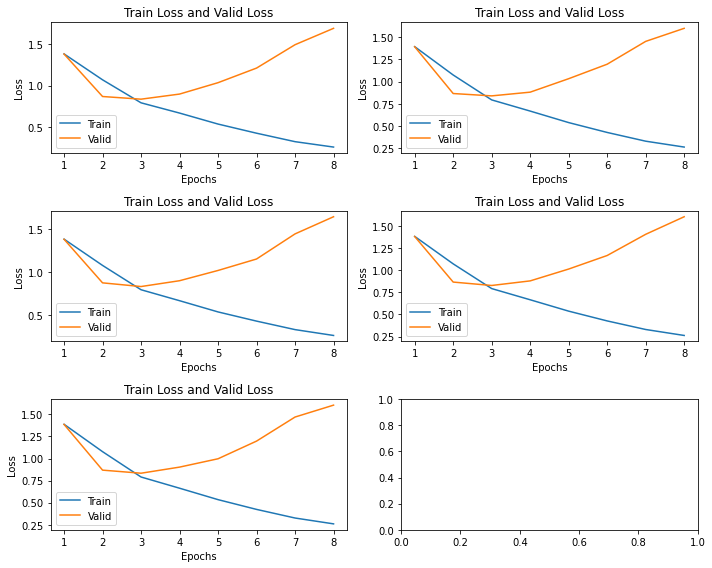

In [111]:
## fold별 epoch당 train loss와 valid loss의 변화
fig ,axs = plt.subplots(3, 2, figsize=(10, 8))
for i, ax in enumerate(axs.flatten()):
    try:
        show_loss_plot(net_epoch_train_loss[i], net_epoch_valid_loss[i], ax)
    except:
        pass
fig.tight_layout()

## test 예측

`-` softmax function을 취하면 4개의 원소 중 최대값의 인덱스 번호가 최종 예측값이 된다

In [122]:
def predict(model: nn.Module, dataloader, weight_save_path, is_prob=False) -> np.array:
    model = model.to(device)
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), num_classes)) ## test예측값

    for weight in weight_path_list :
        model.load_state_dict(torch.load(weight))
        model.eval()
        probs = None
        
        with torch.no_grad(): 
            for test_batch in dataloader:
                test_batch = test_batch.to(device)
                outputs = model(test_batch).cpu().numpy()
                if probs is None:
                    probs = outputs
                else:
                    probs = np.concatenate([probs, outputs])

        test_probs += (probs / N_FOLD)
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스를 반환

    if is_prob:
        return test_probs ## 각 컬럼별 확률값
    return test_preds ## 라벨값

In [138]:
def softmax(arr):
    new_arr = np.exp(arr) / (np.exp(arr[:, 0]).reshape(-1, 1) + np.exp(arr[:, 1]).reshape(-1, 1) + np.exp(arr[:, 2]).reshape(-1, 1) + np.exp(arr[:, 3]).reshape(-1, 1))
    return new_arr

In [113]:
net = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [114]:
test_dataset = CustomDataset(test_tfidf)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch_test)

`-` 가장 확률이 높은 평점이 1 or 2 인지 4 or 5 인지 확인한다

`-` 만약 1 or 2일 확률이 더 높다면 사전 확률을 고려하여 1일 확률이 0.36 이상이면 1로 그 외에는 2로 맵핑한다

`-` 만약 4 or 5일 확률이 더 높다면 사전 확률을 고려하여 4일 확률이 0.2 이상이면 4로 그 외에는 5로 맵핑한다

`-` 단, 표본공간은 그대로 둔다

`-` 단순히 사전 확률으로만 판단하지 않고 적당한 상수를 곱해주어 비교했다

`-` 이유는 적당한 상수를 곱해주었을 때 성능이 더 잘 나왔기 때문이다

- why?

`-` 내 생각, 틀릴 확률 80% 정도

`-` 정확하게 하려면, 예컨대 1 or 2일 확률이 더 높다면 부정적인 리뷰를 다시 예측하여 1점일 확률과 2점일 확률을 구하고 사전 확률을 이용하여 판단해야 한다 

`-` 그런데 리뷰를 다시 예측하지 않으므로 단순히 사전 확률만 사용해 1점일 확률이 0.2보다 높은지를 판단하는 것은 리뷰에 평점을 매기기 애매할수록 주된 라벨 (2 or 5)일 확률이 낮으니까 (이는 1 or 4일 확률이 높음을 의미함) 기존에 의도한 사전 확률보다 1 or 4가 선택될 가능성이 과대 추정된다고 생각한다

In [182]:
def get_label(probs, delta=0.1):
    preds = []
    for prob in probs:
        max_idx = np.argmax(prob)
        if max_idx >= 2: ## 평점은 4 or 5일 확률이 1 or 2일 확률보다 더 높다
            if prob[2] > 0.2 * (1 + delta):
                preds.append(4)
            else:
                preds.append(5)
        else:
            if prob[0] > 0.36 * (1 + delta):
                preds.append(1)
            else:
                preds.append(2)
    return preds

In [161]:
preds = predict(net, test_dataloader, SAVE_PATH, is_prob=True)

In [162]:
probs = softmax(preds)

In [183]:
label = get_label(probs)

In [184]:
submission['target'] = label
submission.head()

,id,target
0,0,2
1,1,1
2,2,5
3,3,1
4,4,1


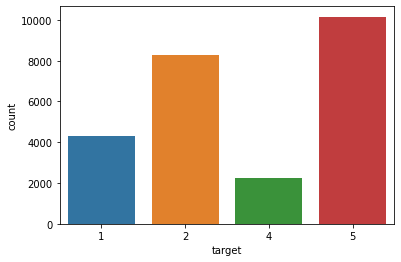

In [185]:
sns.countplot(data=submission, x='target')

In [186]:
submission.to_csv('./Data/submission_RNN2.csv', index=False)